We have a *ton* of options for viz in python.
I'm going to focus on

- matplotlib
- seaborn

At the end, I'll mention Altair, which is new but has a really good design.
There's also Bokeh, which I think has staying power.
I've used it for building semi-complex dashboards, but
it's not part of my day-to-day analysis workflow (yet).

In [6]:
%matplotlib inline

import seaborn.apionly as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('default')

To start with, we'll fetch some data from yahoo using the `pandas_datareader` package.

In [7]:
from pandas_datareader.data import DataReader

stocks = DataReader("GS", data_source="yahoo", start="2006-01-01", end="2016-10-10")
stocks.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2006-01-03,126.699997,129.440002,124.230003,128.869995,6188700,113.747787
2006-01-04,127.349998,128.910004,126.379997,127.089996,4861600,112.176662
2006-01-05,126.000000,127.320000,125.610001,127.040001,3717400,112.132533
2006-01-06,127.290001,129.250000,127.290001,128.839996,4319600,113.721309
2006-01-09,128.500000,130.619995,128.000000,130.389999,4723500,115.089427


# Matplotlib

Not saying much about it, but both seaborn and pandas use matplotlib internally. Their essentialy domanin-specific plotting libraries, using matplotlib as a lower-level framkework.

A few neat things though:

In [8]:
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

People who have used matplotlib for a while will have used the `axes.plot` method; It takes an `x`, `y` and a bunch of keyword arguments.

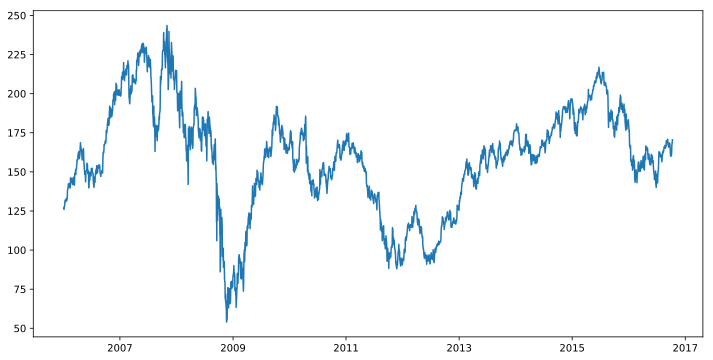

In [11]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(stocks.index, stocks.Open);

As of matplotlib 1.5, all the plot methods `.plot, .bar, .scatter`, etc. take an optional *data* argument. When passed, you can use strings as the `x` and `y`. matplotlib will use these strings as keys for `data.__getitem__`. This means `data` can be DataFrames, dictionaries, even H5py files.

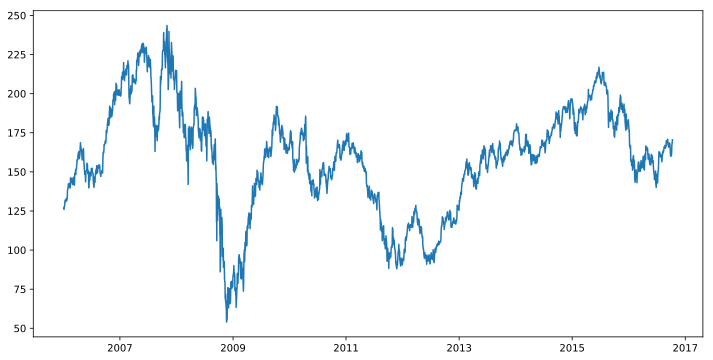

In [12]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot('Open', data=stocks);

With DataFrames, they know that `data.index` is a good default `x` (instead of the usual `range(n)`.

Matplotlib's strength (and weakness) is it's customizability. With enough work, you can make essentially any figure you want.

In [16]:
import statsmodels.tsa.api as smt

In [34]:
ϵ, t = smt.filters.hpfilter(stocks.Close, lamb=129600*30)

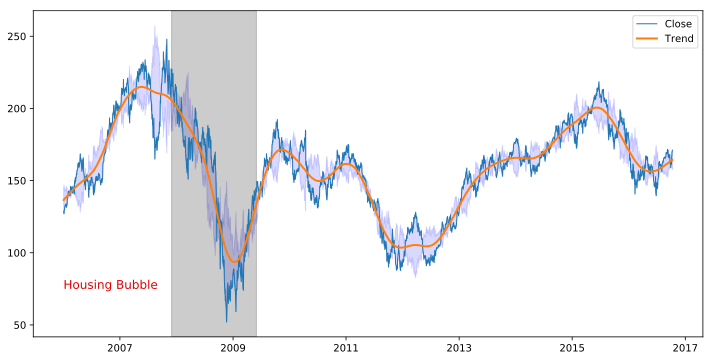

In [60]:
start = pd.Timestamp('2007-12-01')
end = pd.Timestamp('2009-06-01')

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(stocks.Close, linewidth=1)
ax.plot(t, linewidth=2, label="Trend")

ax.fill_between(t.index, (t - ϵ), t + ϵ, alpha=.15, color='b')

ylim = ax.get_ylim()
ax.fill_between([start, end], *ylim, color='k', alpha=.2)
ax.set_ylim(*ylim)

ax.annotate("Housing Bubble", (pd.Timestamp("2006-01-01"),  75),
            fontsize=12, color='xkcd:red')
ax.legend();

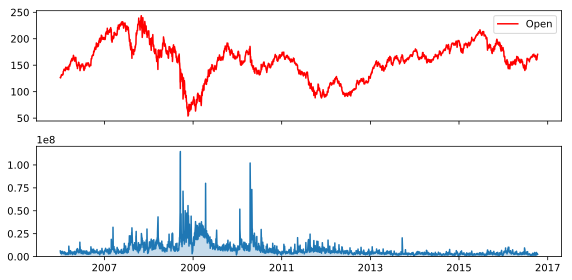

In [61]:
fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(8, 4), sharex=True)

ax1.plot("Open", data=stocks, color='red')
ax2.plot("Volume", data=stocks)
ax2.fill_between(stocks.index, 0, "Volume", data=stocks, alpha=.25)
ax2.set_ylim(0)
ax1.legend()

plt.tight_layout()

Pandas has a few nicities on top of matplotlib:

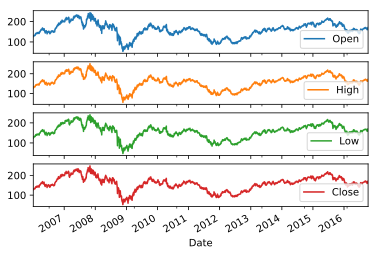

In [62]:
stocks[['Open', 'High', "Low", "Close"]].plot(subplots=True);

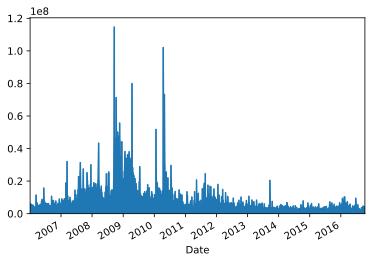

In [63]:
stocks.Volume.plot.area();

In [64]:
%config InlineBackend.figure_format = 'png'
%matplotlib inline

# Seaborn

> Seaborn provides a high-level interface for drawing attractive statistical graphics.

It is *not* a replacement of matplotlib. Rather, it provides a nice API for
many common statistic methods. Some of the distinguishing features are

- Statistical aggregations (`countplot`, bootsrapped standard errors, `regplot`)
- Easier distribution plotting
- Easier faceting by variable

We'll make an update of [this gist](https://gist.github.com/mwaskom/8224591), which explores the titanic dataset:

In [65]:
t = sns.load_dataset('titanic')
t['class'] = t['class'].cat.as_ordered()
t.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [66]:
t.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
survived       891 non-null int64
pclass         891 non-null int64
sex            891 non-null object
age            714 non-null float64
sibsp          891 non-null int64
parch          891 non-null int64
fare           891 non-null float64
embarked       889 non-null object
class          891 non-null category
who            891 non-null object
adult_male     891 non-null bool
deck           203 non-null category
embark_town    889 non-null object
alive          891 non-null object
alone          891 non-null bool
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.2+ KB


In [75]:
pal = dict(man="#4682B4", woman="#CD5C5C", child="#2E8B57", male="#6495ED", female="#F08080")

with sns.color_palette('viridis', n_colors=3) as v:
    pal.update(**dict(zip(['First', 'Second', 'Third'], v.as_hex())))

sns.set(context='talk', style='white')

# Exploratory Analysis

1. Who were the passengers?
2. Who survived?

## Who were the passengers?

Explore them across different dimensions; We'll start with *categorical* data.

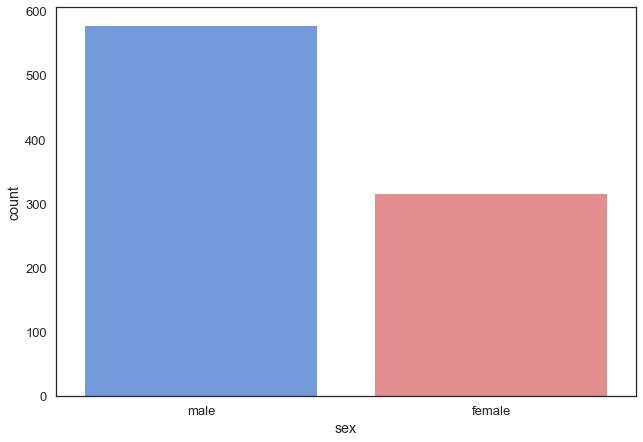

In [76]:
sns.countplot(x="sex", data=t, palette=pal);

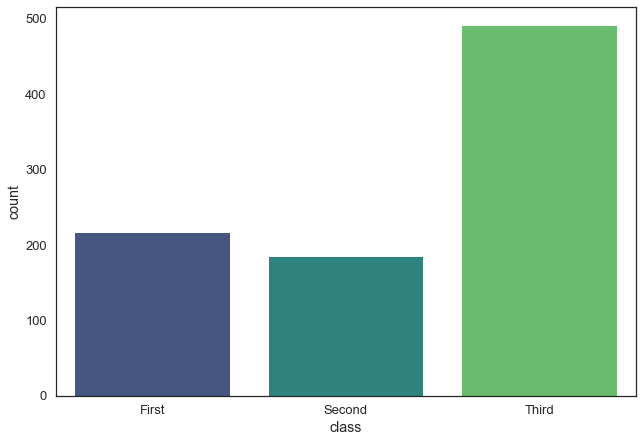

In [79]:
sns.countplot(x="class", data=t, palette=pal);

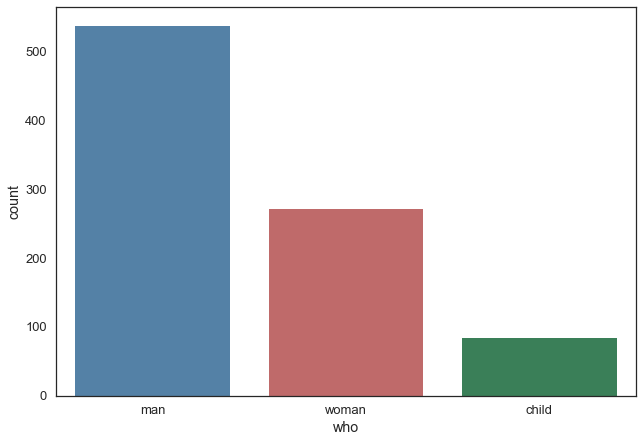

In [80]:
sns.countplot("who", data=t, palette=pal);

Seaborn is built up of a heirarchy of convenience functions and methods. For instance, `countplot` is a specialized version of `factorplot`.

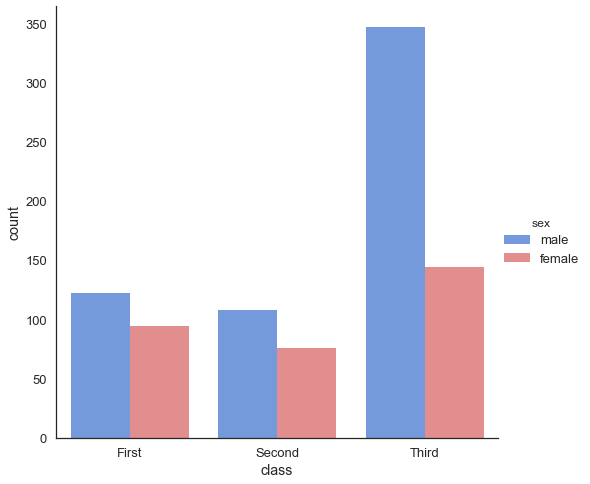

In [81]:
sns.factorplot(x="class", data=t, kind="count", hue="sex",
               palette=pal, size=7);

But *most* functions have the same API. You pass the requeired arguments (`x`, `y`, etc. depending on the plot), a `data` argument. Additional arguments like `hue`, `col`, etc. as needed.

In [82]:
t.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Make a `factorplot` with the counts of `embarked`, with the `hue` split
by `class`.

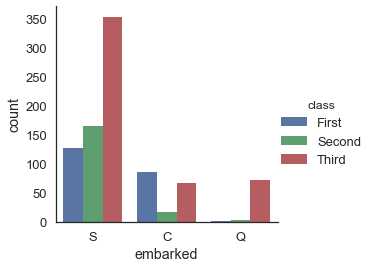

In [84]:
# %load solutions/visualize_00.py
sns.factorplot('embarked', data=t, kind="count", hue="class");


<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Make a pointplot of `age` by `class`. Look at the `kind` parameter to [`sns.pointplot`](https://seaborn.github.io/generated/seaborn.factorplot.html#seaborn.factorplot).

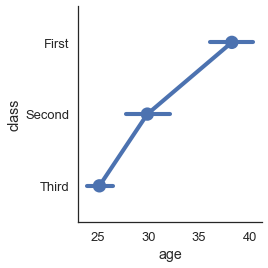

In [86]:
# %load solutions/visualize_01.py
sns.factorplot(x="age", y="class", data=t, kind='point', orient='h');

## Distributions

Let's moving to plotting *quantitative* data:

`FacetGrid` is one of the most useful abstractions in seaborn. You initalize
the `Grid` with all the agruments needed to layout the grid that
will be plotted on:

- `data`: DataFrame
- `row` : variable to facet rows by
- `col` : variable to facet columns by
- `hue` : variable to split colors by

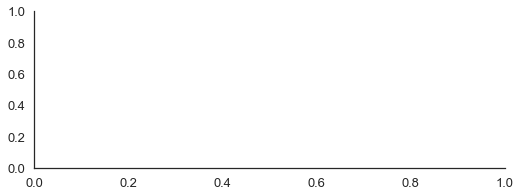

In [87]:
g = sns.FacetGrid(t, hue="sex", aspect=2.5, palette=pal)

We haven't actually done any plotting really.
Just the necessary work to layout the axes.

To actually plot something, `map` plotting functions over the `FacetGrid`. The arguments to `g.map` are passed through.

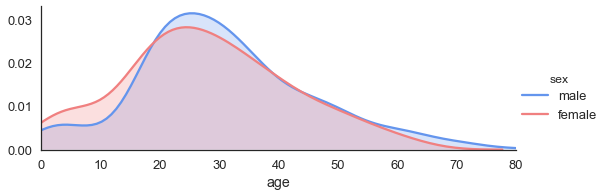

In [88]:
g = sns.FacetGrid(t, hue="sex", aspect=2.5, palette=pal)
g.map(sns.kdeplot, "age", shade=True)
g.set(xlim=(0, 80), ylim=0)
g.add_legend();

To show how the faceting works, pass `row` or `column`:

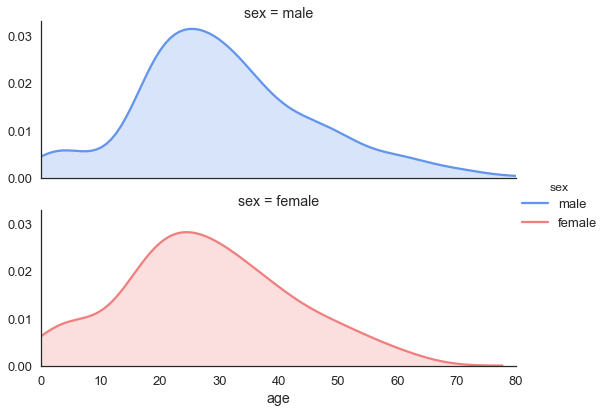

In [89]:
g = sns.FacetGrid(t, row="sex", hue="sex", aspect=2.5, palette=pal)
g.map(sns.kdeplot, "age", shade=True)
g.set(xlim=(0, 80), ylim=0)
g.add_legend();

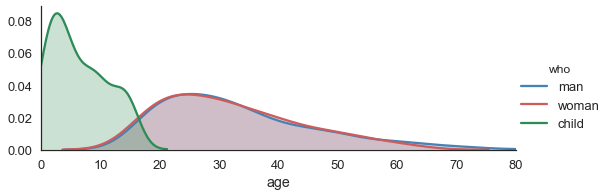

In [90]:
g = sns.FacetGrid(t, hue="who", aspect=2.5, palette=pal)
g.map(sns.kdeplot, "age", shade=True)
g.set(xlim=(0, 80), ylim=0)
g.add_legend();

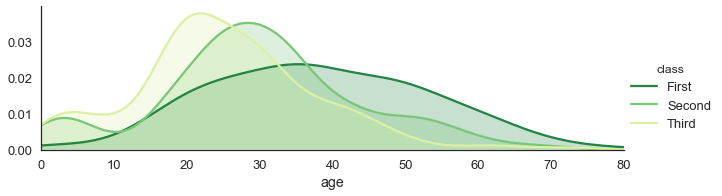

In [91]:
g = sns.FacetGrid(t, hue="class", aspect=3, palette="YlGn_r")
g.map(sns.kdeplot, "age", shade=True)
g.set(xlim=(0, 80), ylim=0)
g.add_legend();

You can get quite complicated results, without much additional work.

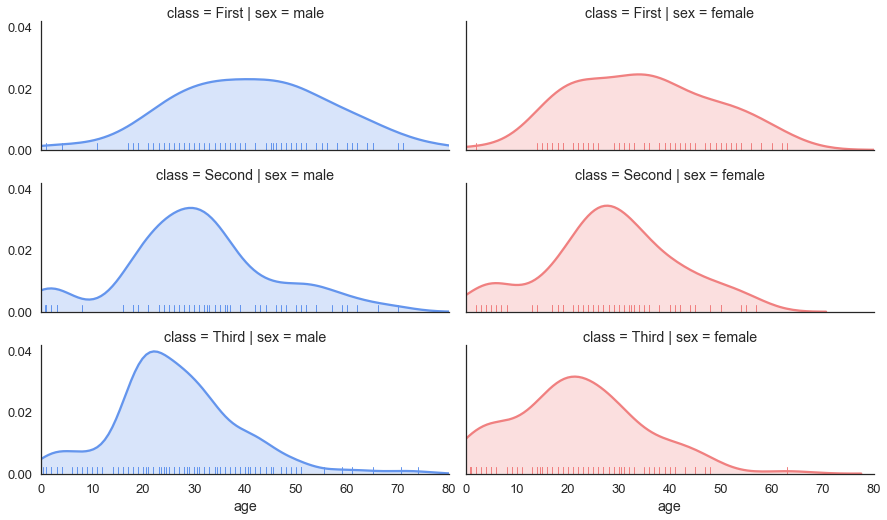

In [92]:
g = (sns.FacetGrid(t, col="sex", row="class", size=2.5, aspect=2.5,
                   palette=pal, hue="sex")
     .map(sns.kdeplot, "age", shade=True)
     .map(sns.rugplot, "age")
     .set(xlim=(0, 80), ylim=0));

This is a great asset when exploring a new dataset.

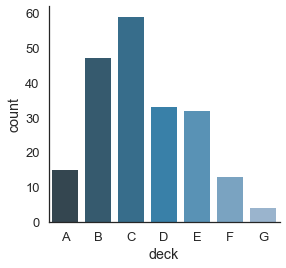

In [93]:
sns.factorplot('deck', data=t, palette='PuBu_d',
               kind="count");

Your data isn't always in perfect shape to be plotted, so you'll be mixing in data manipulations with actual plotting:

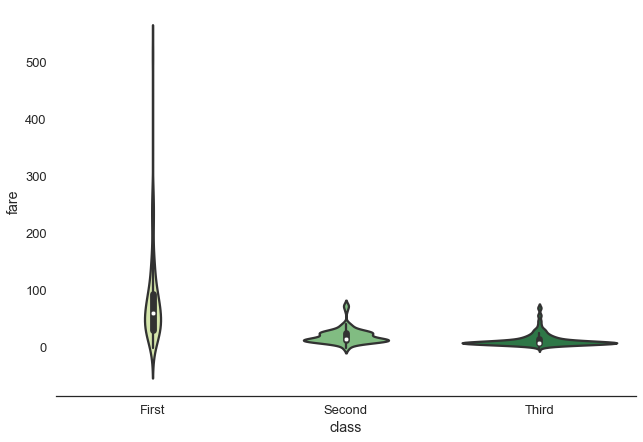

In [94]:
sns.violinplot("class", "fare", data=t, orient="v",
               palette="YlGn")
sns.despine(left=True)

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Create a new column in `t` called `fare_` that topcodes `fare` to be no more than `3 * t.fare.median()`. That is, anything higher than 3x the median should just be set to 3x the median.

Hint: you can use `np.where` to simulate an `if x then y else z` on arrays of data.

In [96]:
# %load solutions/visualize_02a.py
m = t.fare.median()

t['fare_'] = np.where(t.fare < m * 3, t.fare, m * 3)
t.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,fare_
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,7.2500
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,43.3626
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,7.9250
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,43.3626
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,8.0500


Now make the violinplot on fares that we tried above:

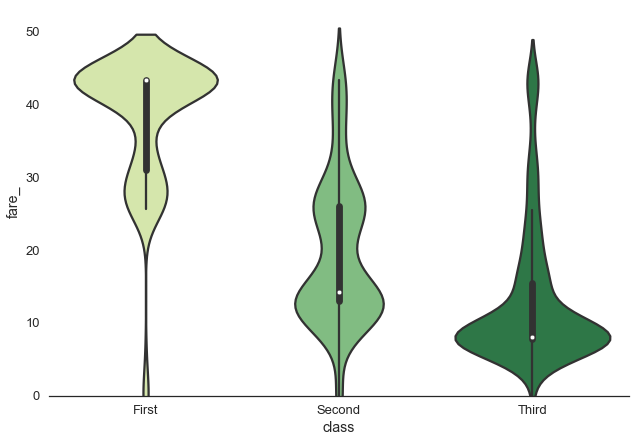

In [98]:
# %load solutions/visualize_02b.py
sns.violinplot("class", "fare_", data=t, orient="v",
               palette="YlGn")
sns.despine(left=True)
plt.ylim(0);


# Plotting Relationships

Thus far we've looked either summary statistics (like countplot), univariate distributions, or basic relationships between one variable and a categorical variable.

Seaborn also provides tools for visualizng bivariate relationships between quantitative variables.

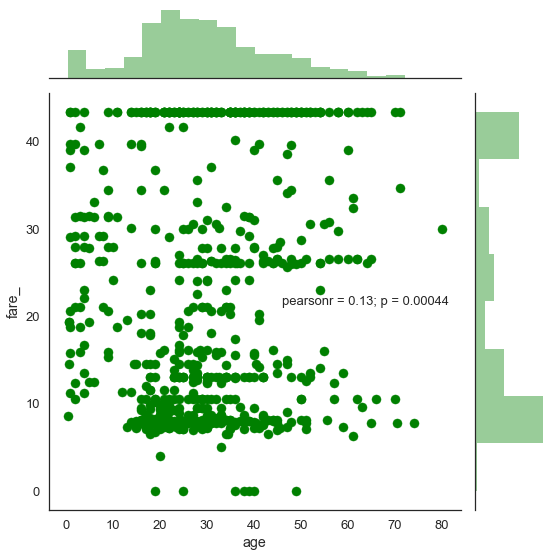

In [99]:
sns.jointplot("age", "fare_", data=t, color="g", size=8);

## Who Survived?

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>

Explore the `"alive"` variable

What does the count of alive look like?

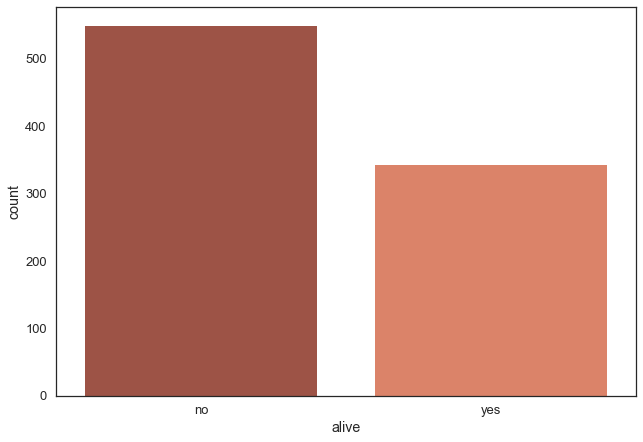

In [101]:
# %load solutions/visualize_03.py
sns.countplot("alive", data=t, palette="OrRd_d");


What's the relationship between class and survived?

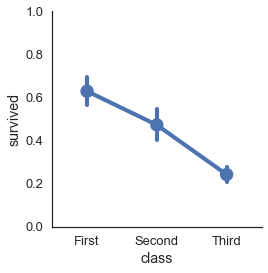

In [103]:
# %load solutions/visualize_04.py
sns.factorplot("class", "survived", data=t).set(ylim=(0, 1));


What's the relationship between who and survived

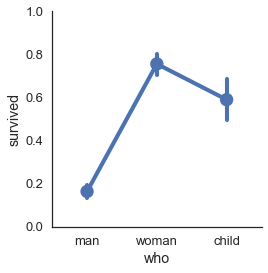

In [105]:
# %load solutions/visualize_05.py
sns.factorplot("who", "survived", data=t).set(ylim=(0, 1));


What's the interaction of `'sex'` with class? Split the `hue` by `sex`.

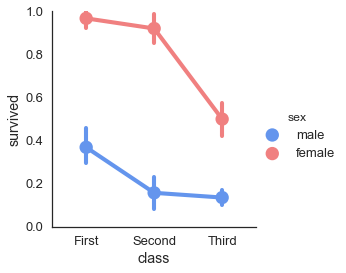

In [107]:
# %load solutions/visualize_06.py
sns.factorplot("class", "survived", data=t,
               hue="sex", palette=pal).set(ylim=(0, 1));


How about the interaction of `'who'` with class?

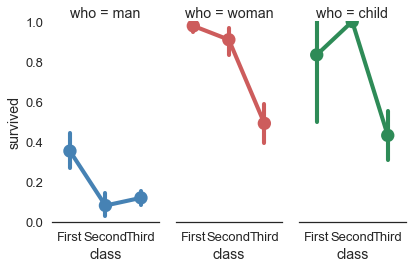

In [109]:
# %load solutions/visualize_07.py
g = sns.factorplot("class", "survived", data=t,
                   hue="who", palette=pal, col="who",
                   aspect=.5)
g.set(ylim=(0, 1))
g.despine(left=True);


What's the relatinoship between `survived` and `adult_male`?

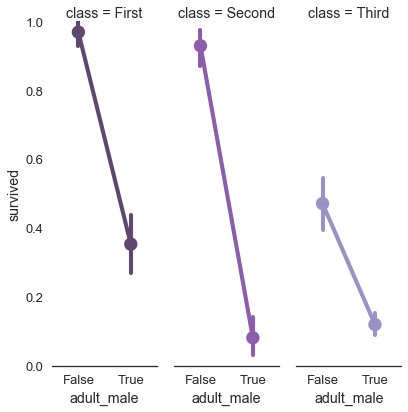

In [112]:
# %load solutions/visualize_08.py
fg = sns.factorplot("adult_male", "survived", data=t,
                    col="class", hue="class", size=6,
                    aspect=.33, palette="BuPu_d")
fg.set(ylim=(0, 1))
fg.despine(left=True);


## Regression plots

You can plot relationships with bet fit lines (and bootstrapped standard errors) using `lmplot`.

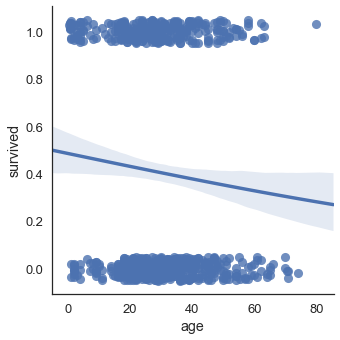

In [114]:
sns.lmplot("age", "survived", t, logistic=True,
           y_jitter=.05);

Since we have a binary target (`survived`), we use `logistic`. It can be more informative to bin the x variable.

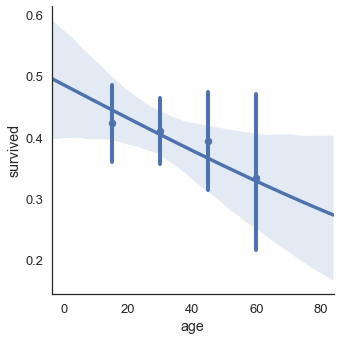

In [115]:
bins = [15, 30, 45, 60]
sns.lmplot("age", "survived", t, logistic=True,
           x_bins=bins);

<div class="alert alert-success">
  <h1><i class="fa fa-tasks" aria-hidden="true"></i> Exercise</h1>
</div>


Can you split that relationship by `sex`?

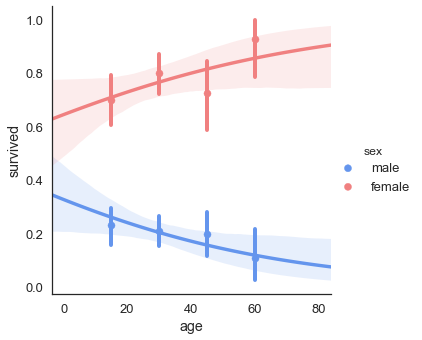

In [118]:
# %load solutions/visualize_09.py
sns.lmplot("age", "survived", t, hue="sex",
           logistic=True, x_bins=bins,
           palette=pal);


How about class?

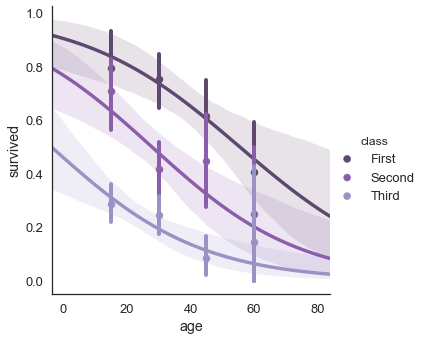

In [120]:
# %load solutions/visualize_10.py
sns.lmplot("age", "survived", t, hue="class",
           logistic=True, x_bins=bins,
           palette="BuPu_d");


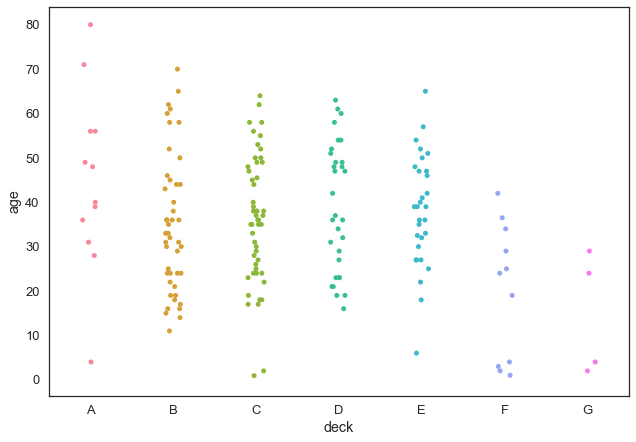

In [121]:
sns.stripplot("deck", "age", data=t, jitter=True);

# [Altair](https://altair-viz.github.io/tutorials/exploring-weather.html)

Altair isn't quite part of my day-to-day toolkit yet, but I think it's well-positioned to become an import tool. It sits at a similar level to seaborn; My interest in Altair is mostly about it's deployment target. Altair is [Vega-Lite](http://vega.github.io/vega-lite/), a JSON syntax for describing visualizatoins. Vega-Lite can be compiled down to [Vega](https://vega.github.io/vega/), which can produce the HTML5 Canvas or SVG needed to render in a browser.

Vega/Vega-Lite is being developed by Jeffrey Heer's group at UW, and Jake VanderPlas (also at UW) has been actively working on Altair this semester.

In [126]:
from altair import load_dataset
df = load_dataset('seattle-weather')
df['date'] = pd.to_datetime(df['date'])
df.head()

,date,precipitation,temp_max,temp_min,wind,weather
0,2012-01-01,0.0,12.8,5.0,4.7,drizzle
1,2012-01-02,10.9,10.6,2.8,4.5,rain
2,2012-01-03,0.8,11.7,7.2,2.3,rain
3,2012-01-04,20.3,12.2,5.6,4.7,rain
4,2012-01-05,1.3,8.9,2.8,6.1,rain


In [127]:
from altair import Chart

Thed basic idea is you initialze a `Chart` with some `data` (typically a pandas DataFrame). You then `encode` columns as visual channels like `x` position, color, or size.

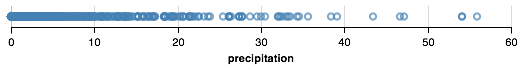

In [132]:
c = Chart(df)
c.mark_point().encode(
    x='precipitation'
)

In [133]:
from altair import Chart, X, Y

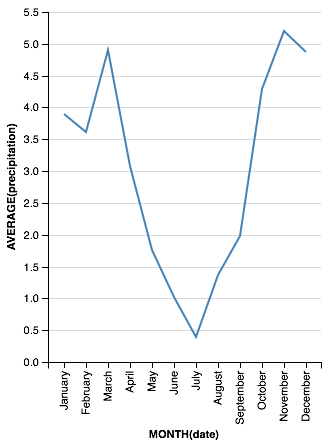

In [134]:
Chart(df).mark_line().encode(
    X('date:T', timeUnit='month'),
    Y('average(precipitation)')
)

I really dislike the `'average(precipitation)'`; Fortunately, Jake just submitted a patch that would let you write it as `y=expr.average(df.precipitation)`.

Again, you can get fancy:

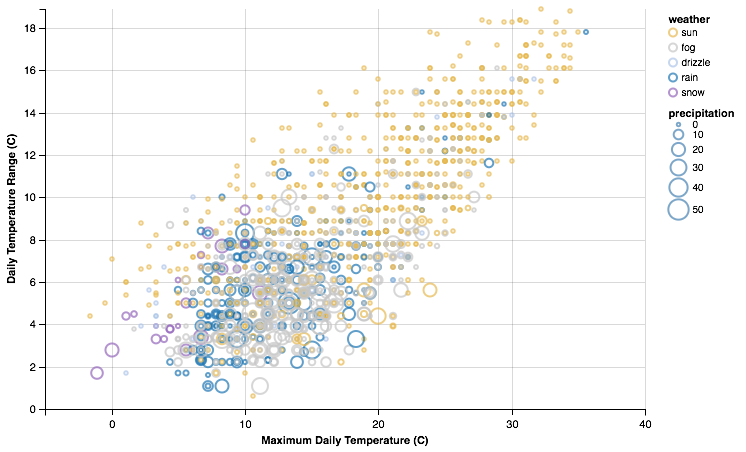

In [135]:
from altair import Chart, X, Y, Color, Formula, Axis, Scale

temp_range = Formula(field='temp_range',
                     expr='datum.temp_max - datum.temp_min')
scale = Scale(domain=['sun', 'fog', 'drizzle', 'rain', 'snow'],
              range=['#e7ba52', '#c7c7c7', '#aec7e8', '#1f77b4', '#9467bd'])

Chart(df).mark_point().encode(
    X('temp_max', axis=Axis(title='Maximum Daily Temperature (C)')),
    Y('temp_range', axis=Axis(title='Daily Temperature Range (C)')),
    Color('weather', scale=scale),
    size='precipitation',
).transform_data(
    calculate=[temp_range]
).configure_cell(width=600, height=400)